For any question or feedback, please contact me [Peyman Ayoubi](https://payoubi.github.io/). This notebook is generated at part of my PhD research at [Caltech](https://www.caltech.edu/). 

#### This notebook generates a 2D spatial correlated random field. It first generates a grid of random numbers, transforms it to wavenumber domain, multiplies it with the assumed correlation function in the wavenumber domain, and transforms the product back to spatial domain. Required parameters are: 
    1) mean value. We use mean shear wave velocity of the medium (vs_mean) 
    2) correlation of variation (COV) by which standard deviation will be calculated (COV)
    3) length scale in X (horizontal) and Z (vertical) directions (theta_x, theta_y)
    4) correlation function (gaussian/exponential/von Karman)
    5) Hurst exponent to be used for von Karman distribution (nu)
    6) length of the domain for stochastic mesh (dx, dz) 
    7) element size for stochastic mesh (ix, iz)
    
The last two parameters can be replaced by information in a numerical PDE solver. This code is implemented in FEM code, SeismoVLAB, which is developed by [Danilo Kusanovic](https://www.linkedin.com/in/danilo-kusanovic-07547b2a/) and  [Elnaz Esmaeilzadeh Seylabi](https://www.unr.edu/cee/people/elnaz-esmaeilzadeh-seylabi), under supervision of Prof. [Domniki Asimaki](https://www.asimaki.caltech.edu/)

In [1]:
import matplotlib.pylab as plt
import numpy as np

This cell fixess the seed. In order to be able to generate the exact same random field, the seed should be fixed. Different realizations of random field can be produced using different seed numbers. 

In [81]:
np.random.seed(1)

Initial parameters needed for the simulation. In the same order as above. 

In [102]:
vs_mean = 220 # mean shear wave velocity
COV = 0.4 # coefficient of variation
vs_std = COV * vs_mean # standard deviation of stochastic velocity field
theta_x=10 # Horizontal length scale 
theta_z=2 # Vertical length scale 
autocorrelation_type = 'gaussian' # type of autocorrelation function "gaussian", "exponential", "vonkarman"
nu=0.2 # Hurst exponent
ix=100 # size of model in same scale as theta_x
iz=50 # size of model in same scale as theta_x
dx=theta_x/5 #  Spatial distance
dz=theta_z/5 #  Spatial distance

This cell creates the stochastic mesh which will be replaced by FEM mesh in the SeismoVLAB code. This also gaurantees the number of grid points is even. 

In [103]:
nx=int(np.ceil(ix/dx))
nz=int(np.ceil(iz/dz))


if (nx/2)!=np.round(nx/2):
    ddx=1 
    nx=nx+ddx
else:
    ddx=0
if (nz/2) != np.round(nz/2):
    ddz=1
    nz=nz+ddz 
else:
    ddz=0
    
x=np.arange(0,nx)*dx 
z=np.arange(0,nz)*dz  

length_x = nx*dx # domain length (X direction)
length_z = nz*dz# domain width (Z direction)

Preparating Fourier domain for 2D transform. 

In [104]:
dkx = 2*np.pi/length_x 
dkz = 2*np.pi/length_z 

kx1 = np.arange(0,nx/2 + 1)*dkx
kx1 = np.hstack((kx1,np.flipud(kx1[1:int(nx/2)])))

kz1 = np.arange(0,nz/2 + 1)*dkz
kz1 = np.hstack((kz1,np.flipud(kz1[1:int(nz/2)])))

[kx,kz]=np.meshgrid(kx1, kz1, indexing='ij')

k=np.sqrt(kx**2*theta_x**2+kz**2*theta_z**2) # wavenumber matrix 

Building the correlation matrix. Three correlation functions are included, namely gaussian, exponential and von Karman. Any other can be simply included here. 

In [105]:
if autocorrelation_type == 'gaussian':
    auto_correl=(length_x*length_z*np.pi*theta_x*theta_z)*np.exp(-(k**2/4)) # PSD of autocorrelation function
    auto_correl=np.sqrt(auto_correl)  # PSD to Fourier transform, Fourier transform is square root of PSD
    
if autocorrelation_type == 'exponential':
    auto_correl=(length_x*length_z*np.pi*theta_x*theta_z)/(1+k**2)**1.5
    auto_correl=np.sqrt(auto_correl)  # PSD to Fourier transform, Fourier transform is square root of PSD

if autocorrelation_type == 'vonkarman':
    auto_correl=(length_x*length_z*np.pi*theta_x*theta_z)/(1+k**2)**(nu+1)
    auto_correl=np.sqrt(auto_correl)  # PSD to Fourier transform, Fourier transform is square root of PSD

Generation of random numbers in a 2D grid of the size nx by nz. Different distribution, namely, normal, lognormal, uniforn, etc., can be used. 

In [106]:
random_data = np.random.normal(0, 1, (nx,nz)) # initial pdf generated by normal distribution 
random_data_transformed = (np.fft.fft2(random_data)) # transforming to wavenumber domain

phase_information = np.angle(random_data_transformed) # getting phase information

Image of generated random field

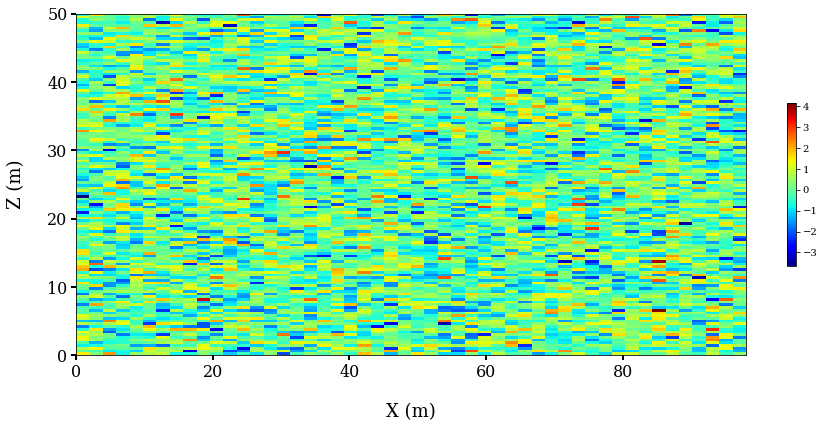

In [107]:
fig = plt.figure(figsize=(15, 10))
axes = plt.gca()

im = axes.imshow(np.transpose(random_data), cmap='jet', aspect='equal', extent=[min(x),max(x),min(z),max(z)], origin='lower')
plt.rc('font', family='serif')
axes.tick_params(direction='out', length=5, width=2,labelsize=16)
plt.xlabel('X (m)', fontsize=18)
plt.ylabel('Z (m)', fontsize=18)
axes.xaxis.labelpad = 22
axes.yaxis.labelpad = 22
fig.colorbar(im,shrink=0.3)
plt.show()

convolution in spatial domain is equivalent to multiplication in wavenumber domain, it is what's happening here. The matrix will then be transformed back to spatial domain and gets scaled to the desired mean shear wave velocity and standard deviation. 

In [108]:
wavenumber_product = auto_correl*np.exp((1j)*phase_information)
spatial_velocity = np.real((np.fft.ifft2(wavenumber_product)))*nx*nz
spatial_velocity = spatial_velocity * dkx *dkz /((2*np.pi)**2)

final_velocity_matrix = vs_mean + vs_std * spatial_velocity # transforming and stretching the output
final_velocity_matrix = np.maximum(80., final_velocity_matrix) # limiting the minimum of velocity values to 80 m/s

Image of final 2D spatially correlated field

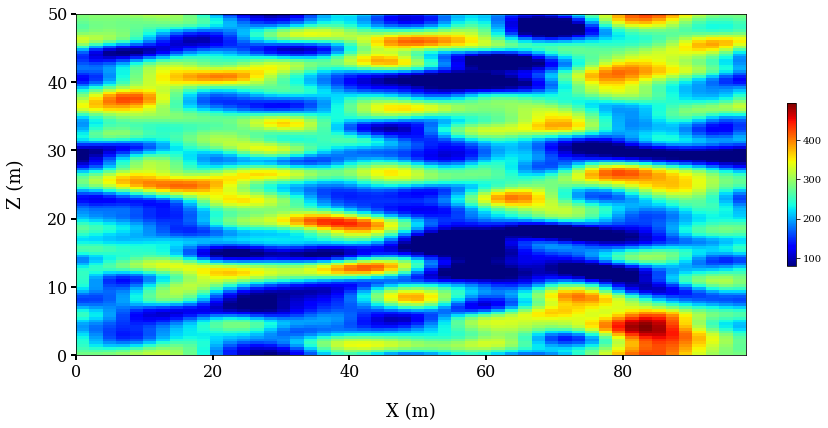

In [109]:
fig = plt.figure(figsize=(15, 10))
axes = plt.gca()

im = axes.imshow(np.transpose(final_velocity_matrix), cmap='jet', aspect='equal', extent=[min(x),max(x),min(z),max(z)], origin='lower')
plt.rc('font', family='serif')
axes.tick_params(direction='out', length=5, width=2,labelsize=16)
plt.xlabel('X (m)', fontsize=18)
plt.ylabel('Z (m)', fontsize=18)
axes.xaxis.labelpad = 22
axes.yaxis.labelpad = 22
fig.colorbar(im,shrink=0.3)

plt.show()

### Refernces
There are numerous articles about the subject but I've found these ones more relevant to geophysical applications. 

    1) Goff, J. A., & Jordan, T. H. (1989). Stochastic modeling of seafloor morphology: A parameterized Gaussian model. Geophysical Research Letters, 16(1), 45-48.
    2) Levander, A., England, R. W., Smith, S. K., Hobbs, R. W., Goff, J. A., & Holliger, K. (1994). Stochastic characterization and seismic response of upper and middle crustal rocks based on the Lewisian gneiss complex, Scotland. Geophysical Journal International, 119(1), 243-259.
    3) Goff, J. A., Holliger, K., & Levander, A. (1994). Modal fields: A new method for characterization of random seismic velocity heterogeneity. Geophysical Research Letters, 21(6), 493-496.
    4) Mai, P. M., & Beroza, G. C. (2002). A spatial random field model to characterize complexity in earthquake slip. Journal of Geophysical Research: Solid Earth, 107(B11), ESE-10.
    5) Nakata, N., & Beroza, G. C. (2015). Stochastic characterization of mesoscale seismic velocity heterogeneity in Long Beach, California. Geophysical Supplements to the Monthly Notices of the Royal Astronomical Society, 203(3), 2049-2054.
    6) Li, J., & Zheng, Y. (2019). Generation of a stochastic binary field that fits a given heterogeneity power spectrum. Geophysical Journal International, 217(1), 294-300.

### Final note

There are many other methods to generate such a random field. One may use covariance matrices (similar to correlation matrices used above) without transferring it to wavenumber domain and use methods like Cholesky decomposition to produce a correlated random field. Moreover, Gaussian Process-like (GP) or Gaussian free field methods are also available. 